In [1]:
#importing libraries
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

In [2]:
#setting connection details
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
#writing a query and getting data from Clickhouse into a df.

query = """
SELECT COUNT()
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count()
0,85207


Download the price data from the table depending on the type of housing. Required columns:

price – price per night room_type – type of rented accommodation (available options: Entire home/apt, Private room, Hotel room, Shared room) Set the limit to 1000 lines. The result should be sorted in ascending order by id.

In [4]:
query2 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
ORDER BY
    id ASC
LIMIT 1000
"""
df2 = ph.read_clickhouse(query2, connection=connection_default)
df2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [5]:
df2 = df2.groupby('room_type') \
    .quantile(q=0.75) \
    .reset_index()

df2.query('room_type == "Private room"')

,room_type,price
2,Private room,70.0


To the data on the price and type of room, additionally upload data on the housing rating (review_scores_rating). In the request, it will be necessary to filter out the empty values of review_scores_rating and convert this column to the float32 type.

Then build a dispersion graph that shows the dependence of the average price on the average estimate, depending on the type of housing.

In [6]:
query3 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM 
    ldn_listings
WHERE 
    review_scores_rating > 0
LIMIT 1000
"""
df3 = ph.read_clickhouse(query3, connection=connection_default)
df3

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


1) group the dataframe by housing type and calculate the average for the price and rating (do not forget to bring the rating to the float type)

2) use sns.scatterplot to plot the dispersion of the average price (X axis) and rating (Y axis) with a breakdown by housing type (hue parameter)

In [7]:
df3 = df3.groupby('room_type') \
    .mean() \
    .reset_index()

df3

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

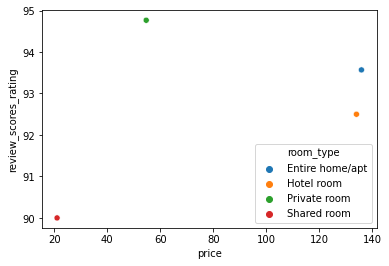

In [8]:
sns.scatterplot(data=df3, x="price", y="review_scores_rating", hue="room_type")

So, in addition to renting housing, there are also "Impressions" on Airbnb — events organized by local residents.

Let's check which account verification methods were used by the hosts offering various impressions (experiences_offered!= 'none'). For each unique user, upload only two columns:

host_id – host identifier (unique)
host_verifications – in what ways the host confirmed his profile

In [9]:
query4 = """
SELECT 
    DISTINCT host_id,
    host_verifications
FROM 
    ldn_listings
WHERE 
    experiences_offered != 'none'
"""
df4 = ph.read_clickhouse(query4, connection=connection_default)
df4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


process the host_verifications column:

The cells contain string representations of the list (for example, as a result of str([1, 2, 3])). Bring facebook to this list, where the used account verification methods will be stored as elements:
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Use the explode and value_counts methods to calculate how many times each verification method occurs

How many hosts have verified the profile using a Google account?

In [10]:
df4.host_verifications

0       ['email', 'phone', 'facebook', 'reviews', 'off...
1       ['email', 'phone', 'reviews', 'jumio', 'govern...
2       ['email', 'phone', 'jumio', 'selfie', 'governm...
3       ['email', 'phone', 'manual_offline', 'jumio', ...
4       ['email', 'phone', 'reviews', 'offline_governm...
                              ...                        
1356    ['email', 'phone', 'reviews', 'jumio', 'govern...
1357    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1358    ['email', 'phone', 'reviews', 'jumio', 'govern...
1359    ['email', 'phone', 'google', 'reviews', 'jumio...
1360    ['email', 'phone', 'reviews', 'manual_offline'...
Name: host_verifications, Length: 1361, dtype: object

In [11]:
df4.host_verifications = df4.host_verifications.apply(lambda x: x.strip('[]').replace("'", '').split(', '))
df4

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [12]:
df4.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


Now let's see for how many ads and in which areas the owners have indicated impressions. Group the data by area and type of impression and count the number of ads. Name the new column experiences_count.

Sort the data in descending order of experiences_count and unload the first 100 rows. Then transform the data using pivot by putting the name of the district in the indexes, the columns are the type of impression, and the values are the number of ads with such an impression for each district. Visualize the result using sms.heatmap() with the palette map=sns.cubehelix_palette(as_map=True).

In [13]:
query5 = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(experiences_offered) AS experiences_count
    
FROM 
    ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC 
LIMIT 100
"""
df5 = ph.read_clickhouse(query5, connection=connection_default)
df5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [14]:
df5_pivot = df5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df5_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

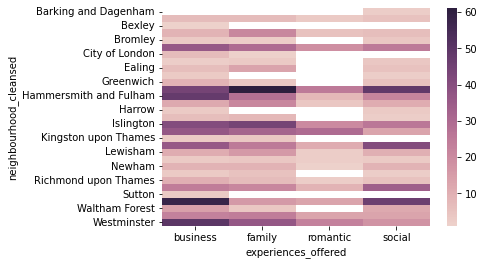

In [15]:
sns.heatmap(df5_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

Upload data on prices per night for different types of housing, for which some kind of impression is also available. Columns required for making a query:

room_type – type of rented accommodation (available options: Entire home/apt, Private room, Hotel room, Shared room)
price – price per night 
experiences_offered – type of available impression (leave not 'none')

In [16]:
query6 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$]', '')) AS price
FROM 
    ldn_listings
WHERE 
    experiences_offered != 'none'
 AND 
    price IS NOT NULL
"""
df6 = ph.read_clickhouse(query6, connection=connection_default)
df6

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1541,Entire home/apt,100.0
1542,Entire home/apt,125.0
1543,Entire home/apt,185.0
1544,Entire home/apt,110.0


Next, build two graphs using distplot from the seaborn library:

On the first one, display the initial price distributions for each type of housing
On the second – logarithmic values (np.log())

In [17]:
df6.room_type.value_counts()

Entire home/apt    920
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


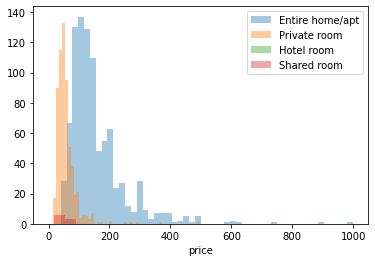

In [18]:
sns.distplot(df6.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df6.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df6.query("room_type=='Hotel room '").price, kde=False, label='Hotel room ')
sns.distplot(df6.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

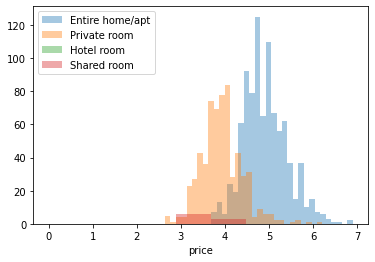

In [19]:
sns.distplot(np.log(df6.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df6.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df6.query("room_type=='Hotel room '").price), kde=False, label='Hotel room ')
sns.distplot(np.log(df6.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

Upload data on the price, type of housing and date of the first review, starting from January 2, 2010. Required columns:

room_type – type of rented accommodation (available options: Entire home/apt, Private room, Hotel room, Shared room)
price – price per night
first_review – date of the first review (filter by the rule "strictly more than 2010-01-01")
Set the limit to 1000 lines.

In [20]:
query7 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$]', '')) AS price,
    first_review
FROM 
    ldn_listings
WHERE 
    first_review > '2010-01-01'
    
LIMIT 1000
"""
df7 = ph.read_clickhouse(query7, connection=connection_default)
df7

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


Using the seaborn library and the lineplot function, plot the dynamics of average house prices (Y-axis) depending on the type of room (line color, hue parameter) by year (X-axis). The dataframe should be sorted by year.


In [21]:
df7.dtypes

room_type        object
price           float32
first_review     object
dtype: object

In [22]:
df7.first_review = df7.first_review.apply(lambda x: x[:-6])
df7

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [23]:
df7_avg = df7.groupby(['room_type', 'first_review'], as_index=False) \
    .agg({'price' : 'mean'}) \
    .rename(columns={"price": "avg_price", "first_review": "year"})
df7_avg

,room_type,year,avg_price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


<AxesSubplot:xlabel='year', ylabel='avg_price'>

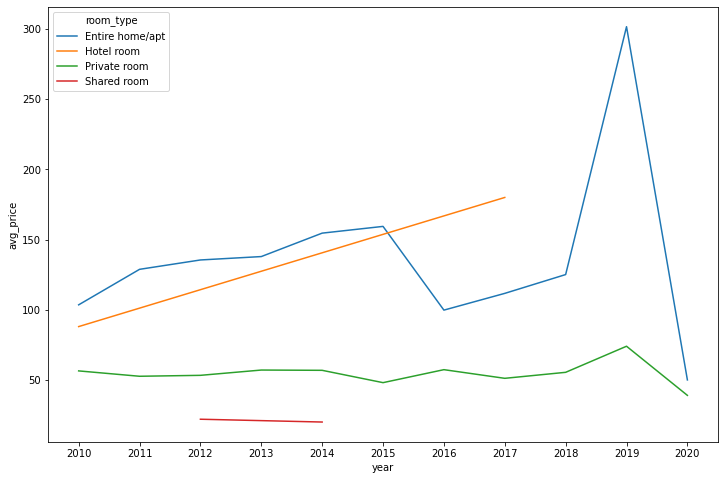

In [24]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df7_avg, x="year", y="avg_price", hue="room_type")